<a href="https://www.kaggle.com/code/fethullahceviz/india-kaggle-2022-survey-data-salary-prediction?scriptVersionId=108333681" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Dataset and Exploration

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor , ExtraTreeRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import  IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_regression
import missingno as msno
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/kaggle-survey-2022/kaggle_survey_2022_responses.csv
/kaggle/input/kaggle-survey-2022/Supplementary Data/kaggle_survey_2022_methodology.pdf
/kaggle/input/kaggle-survey-2022/Supplementary Data/kaggle_survey_2022_answer_choices.pdf


In [2]:
df=pd.read_csv('/kaggle/input/kaggle-survey-2022/kaggle_survey_2022_responses.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,208,225,255,257,260,270,271,277) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df = df[1:]

In [4]:
df.head(3)


,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12
1,121,30-34,Man,India,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,462,30-34,Man,Algeria,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,293,18-21,Man,Egypt,Yes,Coursera,edX,NaN,DataCamp,NaN,...,NaN,"Kaggle (notebooks, forums, etc)",NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...","Podcasts (Chai Time Data Science, O’Reilly Dat...",NaN,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

Duration (in seconds)    object
Q2                       object
Q3                       object
Q4                       object
Q5                       object
                          ...  
Q44_8                    object
Q44_9                    object
Q44_10                   object
Q44_11                   object
Q44_12                   object
Length: 296, dtype: object

In [6]:
df=df[1:]

In [7]:
def missing_value_table(df):
    missing_value = df.isna().sum().sort_values(ascending=False)
    missing_value_percent = 100 * df.isna().sum()//len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percent], axis=1)
    missing_value_table_return = missing_value_table.rename(columns = {0 : 'Missing Values', 1 : '% Value'})
    cm = sns.light_palette("red", as_cmap=True)
    missing_value_table_return = missing_value_table_return.style.background_gradient(cmap=cm)
    return missing_value_table_return

In [8]:
missing_value_table(df)

,Missing Values,% Value
Q36_13,23974,99
Q40_8,23972,99
Q42_5,23970,99
Q37_9,23966,99
Q40_11,23964,99
Q40_5,23961,99
Q41_7,23960,99
Q36_10,23958,99
Q42_6,23957,99
Q40_10,23957,99


In [9]:
# selected Student No and Country India
df = df.loc[(df["Q5"] =='No')& (df["Q4"] =='India')]

In [10]:
# dropped Q5 and Q4
df.drop(['Q5','Q4'], axis=1, inplace=True)

In [11]:
df.shape

(3824, 294)

In [12]:
df['Q23'].replace({'Manager (Program, Project, Operations, Executive-level, etc)'    : 'Manager', 
                   'Data Analyst (Business, Marketing, Financial, Quantitative, etc)': 'Data Analyst'}, inplace=True)

In [13]:
def column_name(name):
    return [col for col in df.columns if name in col]

In [14]:
def count_plot(data):
    return sns.countplot(y=data, order=data.value_counts().index)

## Created Salary Column with Q29

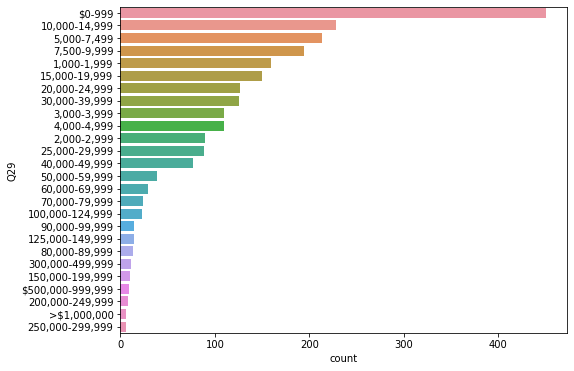

In [15]:
#Q29 What is your current yearly compensation (approximate $USD)?
plt.figure(figsize=(8,6))
count_plot(df.Q29)
plt.xticks(rotation=0)
None

In [16]:
df['Q29']=df['Q29'].str.replace('$','').str.replace(',','').str.replace('>','1000000-')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [17]:
df[['Sal_1', 'Sal_2']]=df['Q29'].str.split('-',n=1, expand=True)
df['Sal_1']=pd.to_numeric(df['Sal_1'])
df['Sal_2']=pd.to_numeric(df['Sal_2'])
df['Salary']=round((df['Sal_1'] + df['Sal_2']) / 2)
df.drop(["Sal_1","Sal_2"], axis=1, inplace=True)

In [18]:
df['Salary'].describe().T

count       2328.000000
mean       25065.399485
std        78191.022114
min          500.000000
25%         1500.000000
50%         8750.000000
75%        22500.000000
max      1000000.000000
Name: Salary, dtype: float64

In [19]:

df['Duration (in seconds)'] = pd.to_numeric(df['Duration (in seconds)'])


# Outlier detection

<AxesSubplot:xlabel='Salary'>

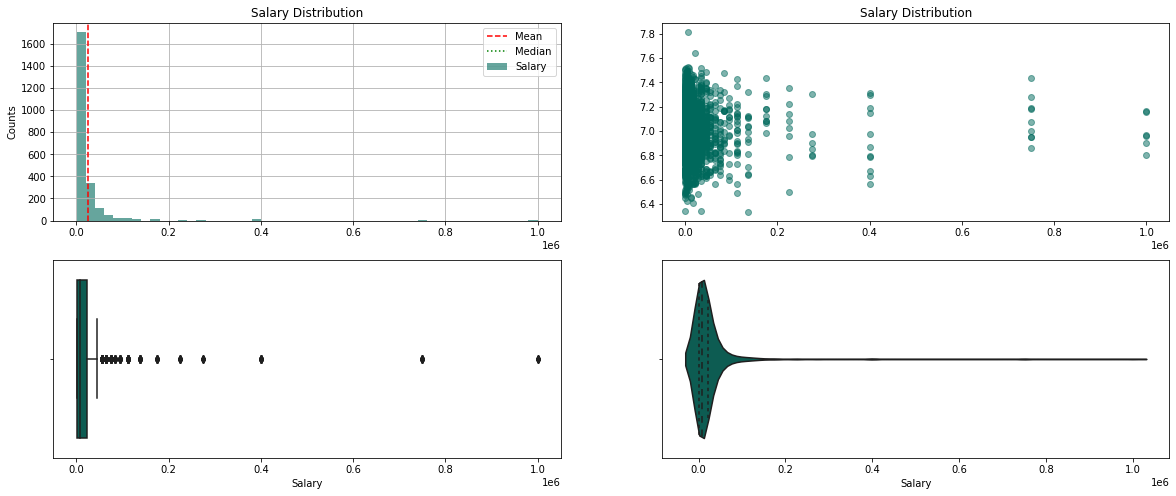

In [20]:
# Outlier Vis.
data=df

plt.figure(figsize=(20, 8))

plt.subplot(2, 2, 1)
data['Salary'].hist(bins=50, label='Salary', alpha=0.6, color='#00695C')
plt.axvline(np.mean(data['Salary']), ls='--', c='r', label="Mean")
plt.axvline(np.median(data['Salary']), ls=':', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Salary Distribution")
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(data['Salary'], np.random.normal(7, 0.2, size=data.shape[0]), alpha=0.5 ,color='#00695C')
plt.title("Salary Distribution")

plt.subplot(2, 2, 3)
sns.boxplot(x="Salary", data=data ,color='#00695C')

plt.subplot(2, 2, 4)
sns.violinplot(x="Salary", data=data, inner="quartile", bw=0.2 ,color='#00695C')

In [21]:
# IQR detection
def outlier(data):
    df_table = data
    Q1 = df_table.quantile(0.25)
    Q3 = df_table.quantile(0.75)
    IQR = Q3-Q1
    alt_sinir = Q1-1.5*IQR
    ust_sinir = Q3+1.5*IQR
    aykiri_tf = (df_table < alt_sinir) | (df_table > ust_sinir)
    index_aykiri_tf= df_table[aykiri_tf].index
    df_table = pd.DataFrame(df_table)
    df_table[~((df_table < (alt_sinir)) | (df_table > (ust_sinir)))]
   
    return index_aykiri_tf 

In [22]:
outlier(df['Salary'])

Int64Index([  245,   514,   581,   656,   712,   837,   887,   927,  1130,
             1157,
            ...
            22565, 22669, 22789, 23120, 23203, 23426, 23474, 23619, 23758,
            23982],
           dtype='int64', length=206)

In [23]:
# 206 outlier drop
df.drop(list(outlier(df.Salary)), axis=0, inplace=True)

In [24]:
# reset index
df= df.reset_index(drop=True)

In [25]:
df.shape

(3618, 295)

In [26]:
#describe Salary Column
df.Salary.describe()

count     2122.000000
mean     10944.745523
std      11818.872284
min        500.000000
25%       1500.000000
50%       6250.000000
75%      17500.000000
max      45000.000000
Name: Salary, dtype: float64

In [27]:
# drop Columns 
df.drop(['Q29'], axis=1, inplace=True)

In [28]:
data = column_name('_')
data_cod = df[data]

## Ordinal Categorical Variable Encoding

In [29]:
# Ordinal Columns Label Encoding
df_ordinal_categorical=df[['Q2','Q8','Q11','Q16','Q25','Q26','Q30','Q43']]

In [30]:
# Label Encoding
df_temp  = df_ordinal_categorical.astype(str).apply(LabelEncoder().fit_transform)
df_final = df_temp.where(~df_ordinal_categorical.isna(), df_ordinal_categorical)
df_final = df_final.add_suffix('_LE')

In [31]:
df_final = df_final.astype('float')

<AxesSubplot:>

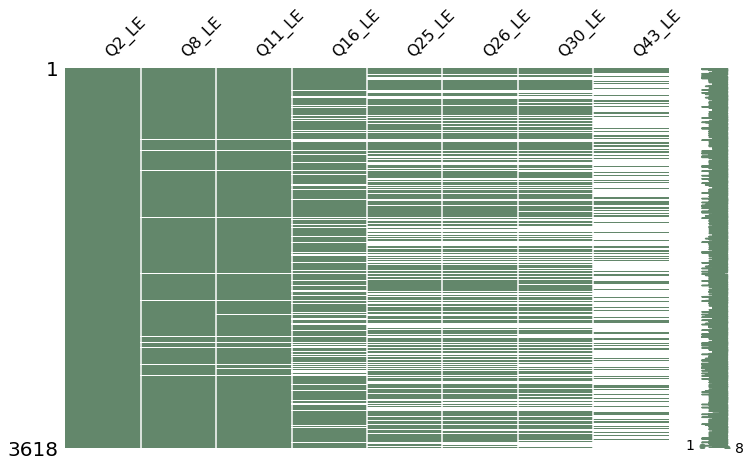

In [32]:
msno.matrix(df_final,figsize=(12, 7), color=(0.39, 0.53, 0.42))

# Missing Value Imputation with IterativeImputer

In [33]:
#newdf = df.select_dtypes(include=np.number)

In [34]:
exEstimator = ExtraTreeRegressor(max_features='sqrt', random_state=42) 
exImputer   = IterativeImputer(estimator=exEstimator, imputation_order='random', verbose = 0 , max_iter = 30 , tol= 1e-10 )
exImputer.fit(df_final)

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(estimator=ExtraTreeRegressor(max_features='sqrt',
                                              random_state=42),
                 imputation_order='random', max_iter=30, tol=1e-10)

In [35]:
exTrans = pd.DataFrame(exImputer.transform(df_final), columns=df_final.columns)

In [36]:
exTrans.isnull().sum()

Q2_LE     0
Q8_LE     0
Q11_LE    0
Q16_LE    0
Q25_LE    0
Q26_LE    0
Q30_LE    0
Q43_LE    0
dtype: int64

In [37]:
df = pd.concat([exTrans, df.reindex(exTrans.index)], axis=1)

In [38]:
df.head()

,Q2_LE,Q8_LE,Q11_LE,Q16_LE,Q25_LE,Q26_LE,Q30_LE,Q43_LE,Duration (in seconds),Q2,...,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Salary
0,4.0,3.0,0.0,6.0,3.0,0.5,0.0,3.0,7548,35-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,3.0,3.0,6.0,1.0,4.0,0.0,0.0,260,35-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,3.0,4.0,7.0,4.0,6.0,5.0,3.0,343,40-44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,2.0,1.0,2.0,1.0,4.0,5.0,3.0,429,40-44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,0.0,3.0,7.0,1.0,2.0,5.0,3.0,1162,22-24,...,"Kaggle (notebooks, forums, etc)",NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,"Slack Communities (ods.ai, kagglenoobs, etc)",NaN,NaN,35000.0


## Get Dummies Nominal Categorical Variable

In [39]:
get_dum_list = ['Q3','Q9','Q22','Q23','Q24','Q27','Q32']
        
for i in get_dum_list:
  gd_df_x = df[i].str.get_dummies().add_prefix(i + '_')
  df      = pd.concat([gd_df_x, df], axis=1, join='inner')

In [40]:
df.shape

(3618, 363)

In [41]:
#Another Columns OneHot encoding 
data_cod.head(4)

,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,...,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,NaN,Udemy,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coursera,NaN,NaN,NaN,NaN,NaN,Udemy,LinkedIn Learning,"Cloud-certification programs (direct from AWS,...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
listem =[]
for i in data_cod.columns:
    listem.append(df[i].dropna().unique()[0])   
    
data_cod = data_cod.replace(np.nan,0).replace(listem,1)

In [43]:
new_column_name_list1=[]

for i in range(len(listem)):
    new_column_name_list1.append('_'+listem[i].split()[0])

In [44]:
new_column_name_list = list(map(str.__add__, data, new_column_name_list1))
data_cod.set_axis(new_column_name_list, axis='columns', inplace=True)   

In [45]:
data_cod.head(4)

,Q6_1_Coursera,Q6_2_edX,Q6_3_Kaggle,Q6_4_DataCamp,Q6_5_Fast.ai,Q6_6_Udacity,Q6_7_Udemy,Q6_8_LinkedIn,Q6_9_Cloud-certification,Q6_10_University,...,Q44_3_Reddit,Q44_4_Kaggle,Q44_5_Course,Q44_6_YouTube,Q44_7_Podcasts,Q44_8_Blogs,Q44_9_Journal,Q44_10_Slack,Q44_11_None,Q44_12_Other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df = pd.concat([df, data_cod], axis=1)

new_df = df.select_dtypes(include=np.number)

# Feature Selection

In [47]:
# FeatureSelection with Mutual info regression

In [48]:
df = new_df.copy(deep = True)

In [49]:
#df_corr= pd.DataFrame(df[df.columns[1:]].corr(method='spearman')['Salary'][:-1])
#df_corr.sort_values(by ='Salary', ascending=False)

In [50]:
# Drop Salary nan values 
df.Salary.isnull().sum()

1496

In [51]:
df = df.dropna(subset=['Salary'], how='any')

In [52]:
X = df.drop('Salary', axis=1)
y = df['Salary']
print(y.shape, X.shape)

(2122,) (2122, 347)


In [53]:
fs  = SelectKBest(score_func=mutual_info_regression, k='all')
fit = fs.fit(X, y)

In [54]:
# first 20 Columns
feature_imp     = pd.DataFrame(fs.scores_, columns=['Score'], index=X.columns)
top20_feature   = feature_imp.nlargest(n=20, columns=['Score'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


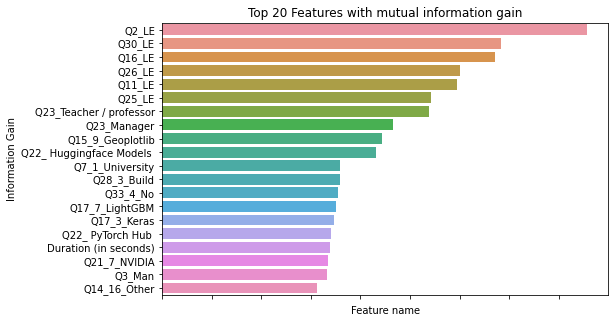

In [55]:
plt.figure(figsize=(8,5))
g = sns.barplot(y=top20_feature.index, x=top20_feature['Score'])
p = plt.title('Top 20 Features with mutual information gain')
p = plt.xlabel('Feature name')
p = plt.ylabel('Information Gain')
p = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

In [56]:
pd.set_option('display.max_rows', 20)

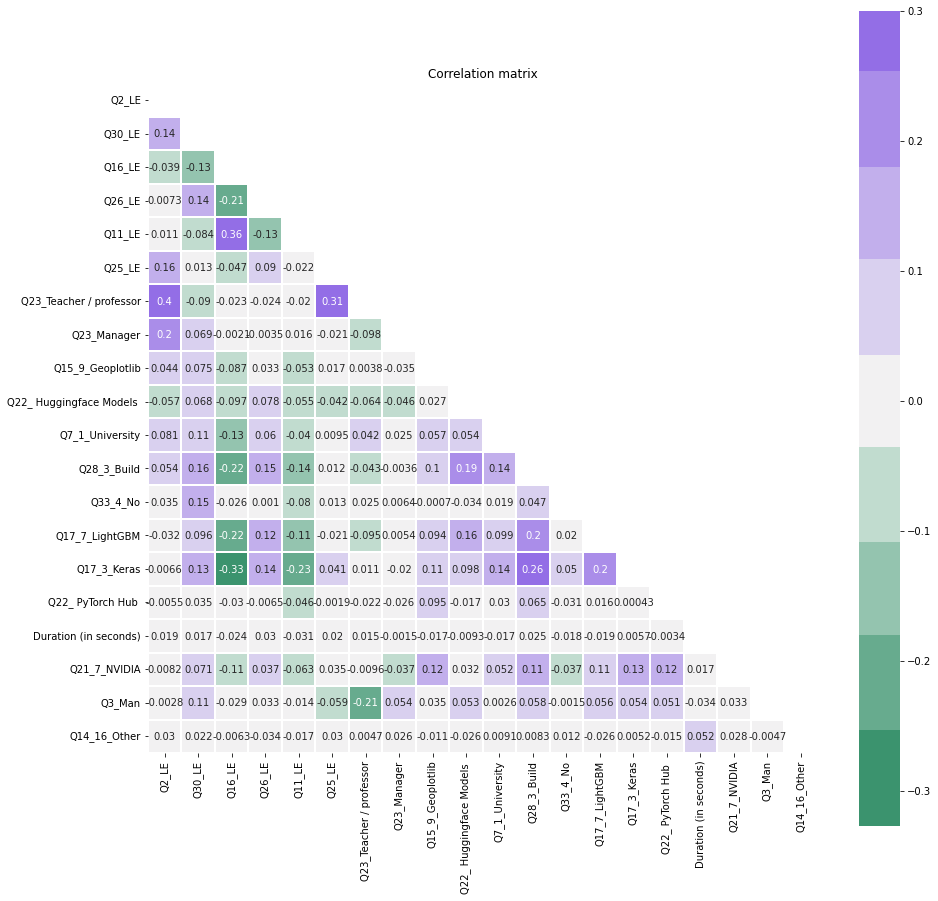

In [57]:
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
plt.figure(figsize=(15, 15))
corr = X[top20_feature.index].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
g = sns.heatmap(corr, annot=True, mask=mask, vmax=0.3, center=0, cmap=cmap, square=True, linewidths=0.05)
p = plt.title('Correlation matrix')

In [58]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(corr, .75)

Q2_LE  Q2_LE   NaN
dtype: float64

In [59]:
X = X[top20_feature.index]
list(X.columns)

['Q2_LE',
 'Q30_LE',
 'Q16_LE',
 'Q26_LE',
 'Q11_LE',
 'Q25_LE',
 'Q23_Teacher / professor',
 'Q23_Manager',
 'Q15_9_Geoplotlib',
 'Q22_ Huggingface Models ',
 'Q7_1_University',
 'Q28_3_Build',
 'Q33_4_No',
 'Q17_7_LightGBM',
 'Q17_3_Keras',
 'Q22_ PyTorch Hub ',
 'Duration (in seconds)',
 'Q21_7_NVIDIA',
 'Q3_Man',
 'Q14_16_Other']

# First Result

In [60]:
#import machine learning algoritma library
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [61]:
# data test-train und standardsclarer
models =[]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [62]:
models.append(("CatBoost", CatBoostRegressor(verbose = False)))
models.append(("LightGBM", LGBMRegressor()))
models.append(("XGBoost", XGBRegressor(verbose = 0)))
models.append(('GBM', GradientBoostingRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
models.append(('CART', DecisionTreeRegressor()))

In [63]:
# first result
firstResultList=[]
for name, model in models:
        model.fit(X_train, y_train)
        y_pred  = model.predict(X_test)
        rmse    = np.sqrt(mean_squared_error(y_test, y_pred))      
        msg     = "%s--> %.2f" % (name, rmse)
        firstResultList.append(msg)

[10:34:15] WARNING: ../src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [64]:
first_score_df = pd.DataFrame({"First Score":firstResultList})
first_score_df


,First Score
0,CatBoost--> 10246.93
1,LightGBM--> 10157.41
2,XGBoost--> 10721.11
3,GBM--> 9949.49
4,RF--> 10193.48
5,KNN--> 11294.72
6,SVR--> 12759.65
7,MLP--> 15166.50
8,CART--> 14344.19


# Model Tuning

## CatBoost

In [65]:
catb_model = CatBoostRegressor(verbose = False)
catb_params = { "iterations"    : [500,1000,10000],
                "learning_rate" : [0.01,0.1,1],
                "depth"         : [2,6,10]}

In [66]:
#catb_cv_model = GridSearchCV( catb_model, catb_params, cv = 5, n_jobs = -1, verbose = 0).fit(X_train, y_train)
#catb_cv_model.best_params_

In [67]:
catb_tuned = CatBoostRegressor( iterations    = 10000,
                                learning_rate = 0.01,
                                depth         = 6 , verbose = False).fit(X_train, y_train)

In [68]:
y_pred = catb_tuned.predict(X_test)
catb_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
catb_tuned_score

10564.692677085424

## LightGBM

In [69]:
lgb_model   = LGBMRegressor()
lgbm_params = { "learning_rate"   : [0.01, 0.1, 1],
                "n_estimators"    : [200,1000,10000],
                "max_depth"       : [2,5,10],
                "colsample_bytree": [1,0.5,0.3]}


In [70]:
#lgbm_cv_model = GridSearchCV(lgb_model, lgbm_params, cv = 10, n_jobs = -1, verbose =2).fit(X_train, y_train)
#lgbm_cv_model.best_params_

In [71]:
lgbm_tuned = LGBMRegressor( learning_rate=0.1,
                            n_estimators=200,
                            max_depth=2,
                            colsample_bytree=0.5).fit(X_train, y_train)

y_pred = lgbm_tuned.predict(X_test)
lgbm_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
lgbm_tuned_score

9988.010009927635

## XGBoost

In [72]:
xgb_params = {"learning_rate"   : [0.1,0.01,1],
             "max_depth"        : [2,5,8],
             "n_estimators"     : [100,500,1000],
             "colsample_bytree" : [0.3,0.6,1]}
xgb = XGBRegressor()

In [73]:
#xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 0).fit(X_train, y_train)
#xgb_cv_model.best_params_

In [74]:
xgb_tuned = XGBRegressor(colsample_bytree = 0.3,
                        learning_rate     = 0.01,
                        max_depth         = 5,
                        n_estimators      = 500).fit(X_train, y_train)

y_pred = xgb_tuned.predict(X_test)
xgb_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_tuned_score


9896.870366961939

## GradientBoostingRegressor

In [75]:
gbm_params = {"learning_rate" : [0.001,0.1,0.01],
              "max_depth"     : [3,5,8],
              "n_estimators"  : [200,500,1000],
              "subsample"     : [1,0.5,0.8] }

gbm_model = GradientBoostingRegressor()

In [76]:
#gbm_cv_model = GridSearchCV(gbm_model,gbm_params, cv = 10, n_jobs=-1, verbose = 2).fit(X_train, y_train)
#gbm_cv_model.best_params_



In [77]:
gbm_tuned = GradientBoostingRegressor(learning_rate = 0.01, 
                                      max_depth     = 3, 
                                      n_estimators  = 500, 
                                      subsample     = 0.5).fit(X_train, y_train)

y_pred = gbm_tuned.predict(X_test)
gbm_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
gbm_tuned_score


10001.632938090619

# Result

In [78]:
# After Tunnig Result
index = ["GBM_tuned","XGB_tuned","LGBM_tuned","CATB_tuned"]
tuned_score_df = pd.DataFrame({"Tuned Score":[gbm_tuned_score, xgb_tuned_score,
                                              lgbm_tuned_score, catb_tuned_score]})
tuned_score_df.index = index
tuned_score_df.sort_values(by='Tuned Score')

,Tuned Score
XGB_tuned,9896.870367
LGBM_tuned,9988.010010
GBM_tuned,10001.632938
CATB_tuned,10564.692677
